In [1]:
import numpy as np

from keras.losses import *
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.utils import to_categorical

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

Using TensorFlow backend.


## First let's make some data
You can modify the funciton, or give any 2D matrix as input **X**, and 1D vector as output **y** od same length

In [9]:
# Return X, y, and plots them on the way
def build_2D_data(num_points=500, num_classes=2):
    num_classes = max(num_classes, 2)
    num_classes = min(num_classes, 4)
    
    X = np.zeros((num_points*num_classes,2)) # data matrix (each row = single example)
    y = np.zeros( num_points*num_classes, dtype='uint8') # class labels
    
    for j in range(num_classes):
        ix = range(num_points*j,num_points*(j+1))
        r = np.linspace(0.0,1,num_points) # radius
        t = np.linspace(j*4,(j+1)*4,num_points) + np.random.randn(num_points)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()
    
    return X, y

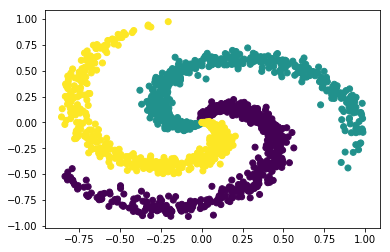

(1500, 2) (1500,) (1500, 3)


In [5]:
X, y = build_2D_data(num_classes=3)
y_cat = to_categorical(y) # let's create a caetgorical version of y. This will be handy later

print(X.shape, y.shape, y_cat.shape)

## Build your model here

In [6]:
l1, l2 = 0, 0
num_neurons = 30
optimizer = adam()
activation = 'relu'

model = Sequential()
model.add(Dense(input_shape = (2,),units=num_neurons,activation=activation,kernel_regularizer=l1_l2(l1, l2)))
model.add(Dense(num_neurons, activation=activation, kernel_regularizer=l1_l2(l1, l2)))
model.add(Dense(num_neurons, activation=activation, kernel_regularizer=l1_l2(l1, l2)))
model.add(Dense(y_cat.shape[-1], activation=activations.softmax))

model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])

## Now the thing itself

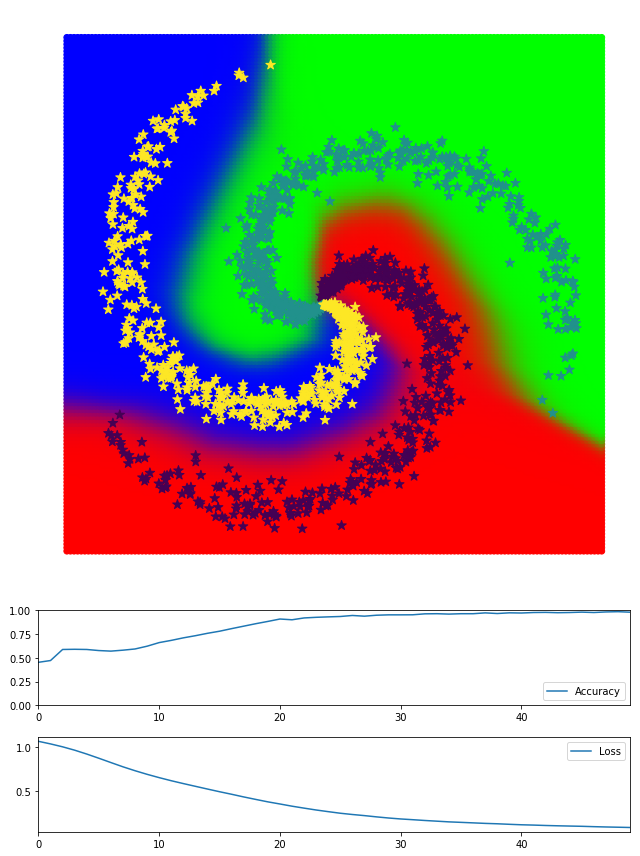

In [7]:
epochs = 50
grid_density = 150 # resolution or density of points on the grid
save_pics = False # weather or not to save the resulting pics the the current directory


# this will keep the information about the loss and accuracy across epochs
logg = np.zeros((epochs, 2)) # frist column for accuracy, the second for the loss

# creating meshgrid to predict every point on it
x = np.linspace(np.min(X)*1.1, np.max(X)*1.1, grid_density)
x1, x2 = np.meshgrid(x, x)

# this will be feed to the network after each epoch, to see what it predicts for each point on the grid
inp = np.stack((x1.flatten(), x2.flatten())).T

for epoch in range(epochs):
    # clearing ouput for new epochs plot
    clear_output(wait=True)
    
    # model predicts every point on our grid
    grid_pred = model.predict_proba(inp)
    
    # creating 3 subplots. 
    # Firts one will be the grid itslef, the second one it accuracy plot, and finally the loss plot
    fig, (grid, acc_perc, loss) = plt.subplots(3, 1, gridspec_kw = {'height_ratios':[6, 1, 1]})
    fig.set_figheight(12)
    fig.set_figwidth(9)
    
    # Frist let's plot predictions for each point on the gird, then the real data points themselves
    c = grid_pred[:,0] if grid_pred.shape[-1] == 2 else grid_pred    
    grid.scatter(x1, x2, c=c)
    grid.scatter(X[:, 0], X[:, 1], s=100, c=y, marker='*')
    grid.axis('off')

    # Let's train the model for one epoch, and save corresponding loss and acc
    hist = model.fit(X, y_cat, epochs=1, batch_size=200, verbose=0, shuffle=True)
    logg[epoch] = (hist.history['acc'][0], hist.history['loss'][0])
    
    # Updating the accuracy plot with data for the current epoch
    acc_perc.set_ylim(bottom=0, top=1)
    acc_perc.set_xlim(left=0, right=epochs-1)
    acc_perc.plot(np.arange(epoch+1), logg[:epoch+1, 0], label='Accuracy')
    acc_perc.legend(loc=4)
    
    # Updating the loss plot with data for the current epoch
    loss.set_xlim(left=0, right=epochs-1)
    loss.plot(np.arange(epoch+1), logg[:epoch+1, 1], label='Loss')
    loss.legend(loc=1)

    plt.tight_layout()   
    
    if save_pics:
        plt.savefig('./pics/epoch_' + str(epoch))
        
    plt.show()